# PCA-based Fault Detection in Truss Structures

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
def q_stat(r):
    q = []
    for i in range(r.shape[0]):
        q.append(np.matmul(r[i], r[i].T))
    return np.array(q)

In [3]:
healthy_path = 'data/healthy.csv'
defective_path = 'data/a6/a6_d50.csv'
num_features = 6

In [4]:
healthy = np.genfromtxt(healthy_path, delimiter=',')[:, :num_features]
defective = np.genfromtxt(defective_path, delimiter=',')[:, :num_features]

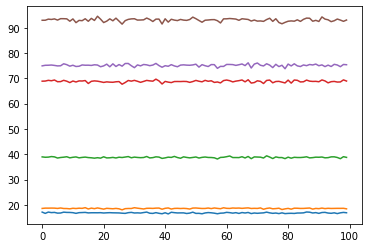

In [5]:
plt.plot(defective)

In [6]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_idx = int(train_ratio * healthy.shape[0])
val_idx = int((train_ratio + val_ratio) * healthy.shape[0])

train = healthy[:train_idx, :]
val_healthy = healthy[train_idx:val_idx, :]
val_defective = defective[train_idx:val_idx, :]
test_healthy = healthy[val_idx:, :]
test_defective = defective[val_idx:, :]

mean = np.mean(train, axis=0)
std = np.std(train, axis=0)

train_n = (train - mean) / std
val_healthy_n = (val_healthy - mean) / std
val_defective_n = (val_defective - mean) / std
test_healthy_n = (test_healthy - mean) / std
test_defective_n = (test_defective - mean) / std

In [7]:
n_pcs, rmses = [], []
var_range = range(90, 100)
for variance_perc in var_range:
    variance_ratio = variance_perc / 100

    pca = PCA(n_components=variance_ratio, svd_solver='full')
    pca.fit(train_n)

    val_trans_n = pca.transform(val_healthy_n)
    n_pc = val_trans_n.shape[1]
    n_pcs.append(n_pc)

    val_healthy_recons_n = pca.inverse_transform(val_trans_n)
    val_healthy_recons = val_healthy_recons_n * std + mean

    rmse = mean_squared_error(val_healthy, val_healthy_recons, squared=False)
    rmses.append(rmse)

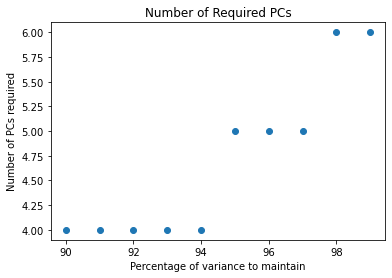

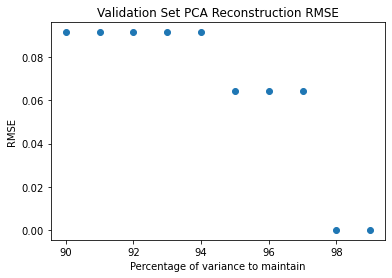

In [8]:
plt.figure()
plt.scatter(var_range, n_pcs)
plt.xlabel('Percentage of variance to maintain')
plt.ylabel('Number of PCs required')
plt.title('Number of Required PCs')
plt.show()

plt.figure()
plt.scatter(var_range, rmses)
plt.xlabel('Percentage of variance to maintain')
plt.ylabel('RMSE')
plt.title('Validation Set PCA Reconstruction RMSE')
plt.show()

In [9]:
variance_ratio = 0.95
pca = PCA(n_components=variance_ratio, svd_solver='full')
pca.fit(train_n)

PCA(n_components=0.95, svd_solver='full')

In [10]:
train_recons_n = pca.inverse_transform(pca.transform(train_n))
train_recons = train_recons_n * std + mean

val_healthy_recons_n = pca.inverse_transform(pca.transform(val_healthy_n))
val_healthy_recons = val_healthy_recons_n * std + mean

val_defective_recons_n = pca.inverse_transform(pca.transform(val_defective_n))
val_defective_recons = val_defective_recons_n * std + mean

test_healthy_recons_n = pca.inverse_transform(pca.transform(test_healthy_n))
test_healthy_recons = test_healthy_recons_n * std + mean

test_defective_recons_n = pca.inverse_transform(pca.transform(test_defective_n))
test_defective_recons = test_defective_recons_n * std + mean

n_pc = pca.transform(val_healthy_n).shape[1]

print(f'Number of PCs required to maintain 95% of the variance: {n_pc}')

Number of PCs required to maintain 95% of the variance: 5


In [11]:
residual_val_healthy = val_healthy_recons - val_healthy
residual_val_defective = val_defective_recons - val_defective

residual_test_healthy = test_healthy_recons - test_healthy
residual_test_defective = test_defective_recons - test_defective

In [12]:
q_train = q_stat(train_recons_n - train_n)
q_val_healthy = q_stat(val_healthy_recons_n - val_healthy_n)
q_val_defective = q_stat(val_defective_recons_n - val_defective_n)
q_test_healthy = q_stat(test_healthy_recons_n - test_healthy_n)
q_test_defective = q_stat(test_defective_recons_n - test_defective_n)

## Classification based on residuals

### Threshold = mean +- threshold_ratio * std

In [13]:
residual_val_healthy_means = np.mean(residual_val_healthy, axis=0)
residual_val_healthy_stds = np.std(residual_val_healthy, axis=0)

residual_lower_limit = residual_val_healthy_means - 3 * residual_val_healthy_stds
residual_higher_limit = residual_val_healthy_means + 3 * residual_val_healthy_stds

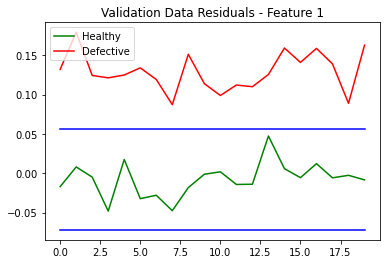

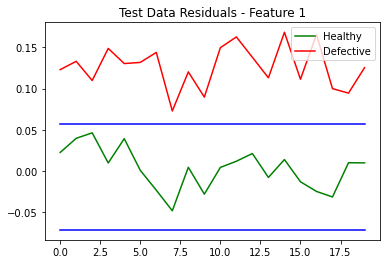

In [14]:
plt.figure()
plt.plot(residual_val_healthy[:, 0], c='g', label='Healthy')
plt.plot(residual_val_defective[:, 0], c='r', label='Defective')
plt.plot(residual_lower_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.plot(residual_higher_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.title('Validation Data Residuals - Feature 1')
plt.legend()
plt.show()

plt.figure()
plt.plot(residual_test_healthy[:, 0], c='g', label='Healthy')
plt.plot(residual_test_defective[:, 0], c='r', label='Defective')
plt.plot(residual_lower_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.plot(residual_higher_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.title('Test Data Residuals - Feature 1')
plt.legend()
plt.show()

In [15]:
threshold_ratios = [i + 1 for i in range(20)]
fpr, tpr = [], []  # False positive and true positive ratios
for thr in threshold_ratios:
    residual_lower_limit = residual_val_healthy_means - thr * residual_val_healthy_stds
    residual_higher_limit = residual_val_healthy_means + thr * residual_val_healthy_stds
    y_val_healthy = np.zeros(residual_val_healthy.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
    y_val_defective = np.zeros(residual_val_defective.shape)
    for j in range(residual_val_healthy.shape[1]):
        for i in range(residual_val_healthy.shape[0]):
            if not residual_lower_limit[j] <= residual_val_healthy[i, j] <= residual_higher_limit[j]:
                y_val_healthy[i, j] = 1
    for j in range(residual_val_defective.shape[1]):
        for i in range(residual_val_defective.shape[0]):
            if not residual_lower_limit[j] <= residual_val_defective[i, j] <= residual_higher_limit[j]:
                y_val_defective[i, j] = 1
    y_val_healthy = np.max(y_val_healthy, axis=1)
    y_val_defective = np.max(y_val_defective, axis=1)
    fpr.append(np.count_nonzero(y_val_healthy) / y_val_healthy.shape[0])
    tpr.append(np.count_nonzero(y_val_defective) / y_val_defective.shape[0])

print(f'False positive rates: {fpr}')
print(f'True positive rates: {tpr}')
print(f'Threshold ratios: {threshold_ratios}')

False positive rates: [0.25, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True positive rates: [1.0, 1.0, 1.0, 1.0, 0.85, 0.65, 0.25, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Threshold ratios: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


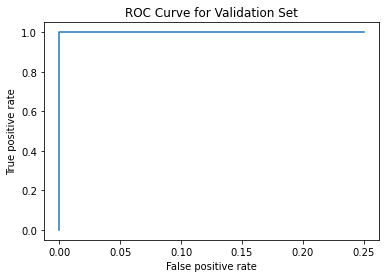

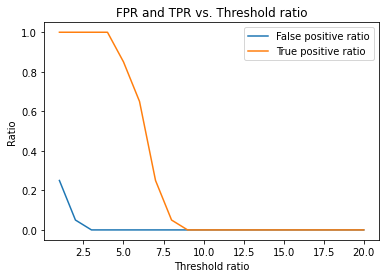

In [16]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for Validation Set')
plt.show()

plt.figure()
plt.plot(threshold_ratios, fpr, label='False positive ratio')
plt.plot(threshold_ratios, tpr, label='True positive ratio')
plt.xlabel('Threshold ratio')
plt.ylabel('Ratio')
plt.legend()
plt.title('FPR and TPR vs. Threshold ratio')
plt.show()

In [17]:
if np.min(fpr) == 0 and np.max(tpr) == 1:    
    idx = np.int_(np.where(np.logical_and(np.logical_not(np.bool_(fpr)), np.bool_(np.floor(tpr))))[0])
    selected_threshold_ratios = np.array(threshold_ratios)[idx]
    print(f'Selected threshold ratios: {selected_threshold_ratios}')

    selected_threshold_ratio = int(np.median(selected_threshold_ratios))
    print(f'Selected threshold ratio: {selected_threshold_ratio}')
    residual_lower_limit = residual_val_healthy_means - selected_threshold_ratio * residual_val_healthy_stds
    residual_higher_limit = residual_val_healthy_means + selected_threshold_ratio * residual_val_healthy_stds

Selected threshold ratios: [3 4]
Selected threshold ratio: 3


In [18]:
y_test_healthy = np.zeros(residual_test_healthy.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
y_test_defective = np.zeros(residual_test_defective.shape)
for j in range(residual_test_healthy.shape[1]):
    for i in range(residual_test_healthy.shape[0]):
        if not residual_lower_limit[j] <= residual_test_healthy[i, j] <= residual_higher_limit[j]:
            y_test_healthy[i, j] = 1
for j in range(residual_test_defective.shape[1]):
    for i in range(residual_test_defective.shape[0]):
        if not residual_lower_limit[j] <= residual_test_defective[i, j] <= residual_higher_limit[j]:
            y_test_defective[i, j] = 1
y_test_healthy = np.max(y_test_healthy, axis=1)
y_test_defective = np.max(y_test_defective, axis=1)
y_test_pre = np.concatenate((y_test_healthy, y_test_defective))
y_test_true = np.concatenate((np.zeros(y_test_healthy.shape[0]), np.ones(y_test_defective.shape[0])))

fpr_test = np.count_nonzero(y_test_healthy) / y_test_healthy.shape[0]
tpr_test = np.count_nonzero(y_test_defective) / y_test_defective.shape[0]

accuracy_test = accuracy_score(y_test_true, y_test_pre)

print(f'Test set FPR = {fpr_test}')
print(f'Test set TPR = {tpr_test}')
print(f'Test set accuracy = {accuracy_test}')

Test set FPR = 0.0
Test set TPR = 1.0
Test set accuracy = 1.0


### Threshold fixed to the minimum with no false positives for healthy validation data

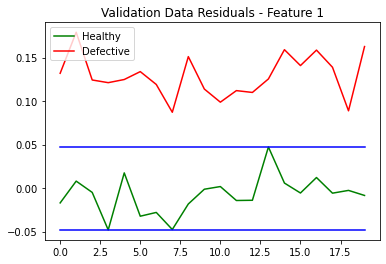

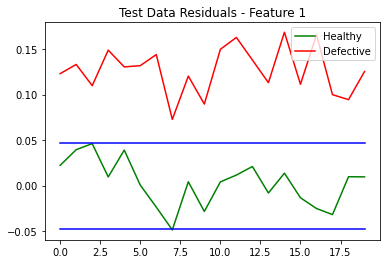

In [19]:
residual_lower_limit = np.min(residual_val_healthy, axis=0)
residual_higher_limit = np.max(residual_val_healthy, axis=0)

plt.figure()
plt.plot(residual_val_healthy[:, 0], c='g', label='Healthy')
plt.plot(residual_val_defective[:, 0], c='r', label='Defective')
plt.plot(residual_lower_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.plot(residual_higher_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.title('Validation Data Residuals - Feature 1')
plt.legend()
plt.show()

plt.figure()
plt.plot(residual_test_healthy[:, 0], c='g', label='Healthy')
plt.plot(residual_test_defective[:, 0], c='r', label='Defective')
plt.plot(residual_lower_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.plot(residual_higher_limit[0] * np.ones(residual_val_healthy.shape[0]), c='b')
plt.title('Test Data Residuals - Feature 1')
plt.legend()
plt.show()

In [20]:
y_test_healthy = np.zeros(residual_test_healthy.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
y_test_defective = np.zeros(residual_test_defective.shape)
for j in range(residual_test_healthy.shape[1]):
    for i in range(residual_test_healthy.shape[0]):
        if not residual_lower_limit[j] <= residual_test_healthy[i, j] <= residual_higher_limit[j]:
            y_test_healthy[i, j] = 1
for j in range(residual_test_defective.shape[1]):
    for i in range(residual_test_defective.shape[0]):
        if not residual_lower_limit[j] <= residual_test_defective[i, j] <= residual_higher_limit[j]:
            y_test_defective[i, j] = 1
y_test_healthy = np.max(y_test_healthy, axis=1)
y_test_defective = np.max(y_test_defective, axis=1)
y_test_pre = np.concatenate((y_test_healthy, y_test_defective))
y_test_true = np.concatenate((np.zeros(y_test_healthy.shape[0]), np.ones(y_test_defective.shape[0])))

fpr_test = np.count_nonzero(y_test_healthy) / y_test_healthy.shape[0]
tpr_test = np.count_nonzero(y_test_defective) / y_test_defective.shape[0]

accuracy_test = accuracy_score(y_test_true, y_test_pre)

print(f'Test set FPR = {fpr_test}')
print(f'Test set TPR = {tpr_test}')
print(f'Test set accuracy = {accuracy_test}')

Test set FPR = 0.05
Test set TPR = 1.0
Test set accuracy = 0.975


## Classification based on Q-statistic

In [21]:
c_alpha = 1.65  # normal deviate corresponding to 95 percentile
cov = np.cov(train_n.T)
d, _ = np.linalg.eig(cov)
d = np.sort(d)[::-1]
theta = []
for i in range(3):
    theta.append(np.sum(np.array(d[n_pc:]) ** (i + 1)))
h_0 = 1 - (2 * theta[0] * theta[2]) / (3 * theta[1] ** 2)
q_alpha = theta[0] * np.power((c_alpha * h_0 * np.sqrt(2 * theta[1]) / theta[0] + 1 + theta[1] * h_0 * (h_0 - 1) / theta[0] ** 2), 1 / h_0)
print(q_alpha)

0.5866215919209365


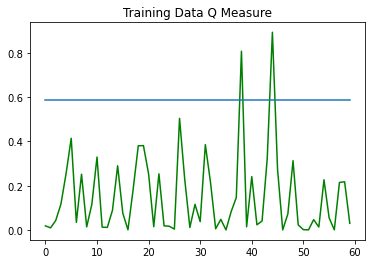

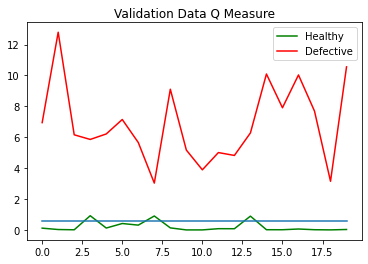

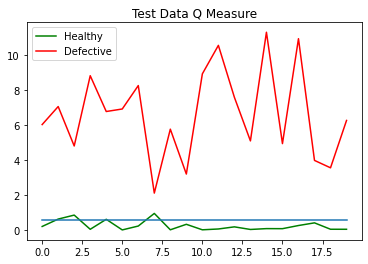

In [22]:
plt.figure()
plt.plot(q_train, c='g')
plt.plot([q_alpha] * q_train.shape[0])
plt.title('Training Data Q Measure')
plt.show()

plt.figure()
plt.plot(q_val_healthy, c='g', label='Healthy')
plt.plot(q_val_defective, c='r', label='Defective')
plt.plot([q_alpha] * q_val_healthy.shape[0])
plt.title('Validation Data Q Measure')
plt.legend()
plt.show()

plt.figure()
plt.plot(q_test_healthy, c='g', label='Healthy')
plt.plot(q_test_defective, c='r', label='Defective')
plt.plot([q_alpha] * q_val_healthy.shape[0])
plt.title('Test Data Q Measure')
plt.legend()
plt.show()

In [23]:
y_test_healthy = np.zeros(q_test_healthy.shape)  # 0 = Healthy (negative), 1 = Failed (positive)
y_test_defective = np.zeros(q_test_defective.shape)

for i in range(q_test_healthy.shape[0]):
    if not q_test_healthy[i] <= q_alpha:
        y_test_healthy[i] = 1
        
for i in range(q_test_defective.shape[0]):
    if not q_test_defective[i] <= q_alpha:
        y_test_defective[i] = 1

y_test_pre = np.concatenate((y_test_healthy, y_test_defective))
y_test_true = np.concatenate((np.zeros(y_test_healthy.shape[0]), np.ones(y_test_defective.shape[0])))

fpr_test = np.count_nonzero(y_test_healthy) / y_test_healthy.shape[0]
tpr_test = np.count_nonzero(y_test_defective) / y_test_defective.shape[0]

accuracy_test = accuracy_score(y_test_true, y_test_pre)

print(f'Test set FPR = {fpr_test}')
print(f'Test set TPR = {tpr_test}')
print(f'Test set accuracy = {accuracy_test}')

Test set FPR = 0.2
Test set TPR = 1.0
Test set accuracy = 0.9


## DIM Analysis

In [24]:
q_0 = q_val_defective

delta_qs = []
for f in range(val_defective_n.shape[1]):
    min_r = np.min(val_defective_n[:, f])
    max_r = np.max(val_defective_n[:, f])
    increment = (max_r - min_r) / 100
    val_defective_plus_n = val_defective_n.copy()
    val_defective_minus_n = val_defective_n.copy()
    for i in range(val_defective_n.shape[0]):
        val_defective_plus_n[i, f] += increment
        val_defective_minus_n[i, f] -= increment
    val_defective_plus_n_recons = pca.inverse_transform(pca.transform(val_defective_plus_n))
    val_defective_minus_n_recons = pca.inverse_transform(pca.transform(val_defective_minus_n))
    residual_val_defective_plus_n = val_defective_plus_n_recons - val_defective_plus_n
    residual_val_defective_minus_n = val_defective_minus_n_recons - val_defective_minus_n
    q_plus = q_stat(residual_val_defective_plus_n)
    q_minus = q_stat(residual_val_defective_minus_n)
    q = np.maximum (q_plus, q_minus)
    delta_q = q - q_0
    delta_qs.append(delta_q)
delta_qs = np.array(delta_qs).T
delta_qs_sum = np.sum(delta_qs, axis=1)
dim = []
for i in range(delta_qs.shape[0]):
    dim.append(delta_qs[i, :] / delta_qs_sum[i])
dim = np.array(dim)

dim_mean = np.mean(dim, axis=0)
dim_std = np.std(dim, axis=0)

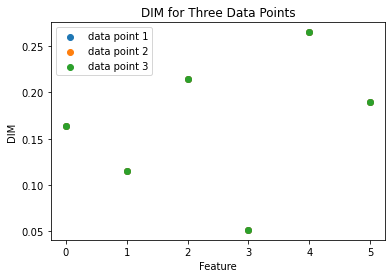

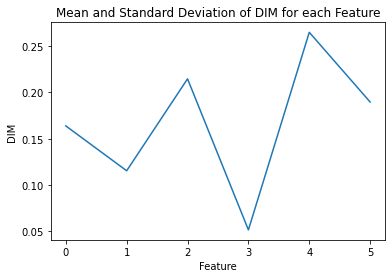

In [25]:
plt.figure()
for i in range(3):
    plt.scatter(range(dim[i, :].shape[0]), dim[i, :], label=f'data point {i + 1}')
plt.xlabel('Feature')
plt.ylabel('DIM')
plt.title('DIM for Three Data Points')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(range(dim_mean.shape[0]), dim_mean, dim_std)
plt.xlabel('Feature')
plt.ylabel('DIM')
plt.title('Mean and Standard Deviation of DIM for each Feature')
plt.show()

In [26]:
dim_mean = list(dim_mean)
dim_test = dim_mean.copy()
dim_order = []
while len(dim_test) > 0:
    max_dim = np.max(dim_test)
    max_idx = dim_mean.index(max_dim)
    dim_order.append(max_idx)
    dim_test.pop(dim_test.index(max_dim))

print(f'Components in order of importance: {dim_order}')

Components in order of importance: [4, 2, 5, 0, 1, 3]
